# Term Deposit Prediction - Model Monitoring

### Learning Objectives

- Demonstrate the importance of monitoring workflows in MLOps practices.
- Showcase statistical models used to detect various types of drift in models deployed in production.

In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 40.5 MB/s eta 0:00:00


# Setup

In [ ]:
import math  # Import the math module for mathematical functions
import pandas as pd  # Import pandas for data manipulation

import matplotlib.pyplot as plt  # Import matplotlib for plotting
import seaborn as sns  # Import seaborn for visualization enhancements

from datasets import load_dataset  # Import load_dataset function from datasets module

from sklearn.model_selection import train_test_split  # Import train_test_split for splitting datasets
from sklearn.metrics import classification_report  # Import classification_report for model evaluation

In [ ]:
# Set the context for seaborn plots
sns.set_context('talk')

# Monitoring Setup

## Access Training Data

In [ ]:
# Read the dataset from the CSV file into a DataFrame
data_df = pd.read_csv("Bank_Telemarketing.csv")

# Drop the specified columns from the DataFrame
data_df = data_df.drop(columns=['customer_id', 'email_id', 'first_name', 'last_name'])

# Define numerical and categorical feature columns
numerical_features = data_df[['Age', 'Duration(Sec)', 'CC Contact Freq', 'Days Since PC', 'PC Contact Freq']].columns
categorical_features = data_df.select_dtypes(include=['object']).columns

# Separate features (X) and target variable (y)
X = data_df.drop('subscribed', axis=1)
y = data_df['subscribed']

# Split the dataset into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Rearrange the columns in to numerical and categorical features
Xtest = Xtest[['Age', 'Duration(Sec)', 'CC Contact Freq', 'Days Since PC',
               'PC Contact Freq','Job', 'Marital Status', 'Education', 'Defaulter', 'Home Loan',
               'Personal Loan', 'Communication Type', 'Last Contacted', 'Day of Week',
               'PC Outcome']]

## Access Logs

We connect to the dataset of all the production logs and extract a 30% random sample to execute the monitoring workflow.

In [ ]:
prediction_logs = load_dataset("---PASTE YOUR LOGS DATASET API---------")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/253 [00:00<?, ? examples/s]

In [ ]:
# Convert the 'train' split from prediction_logs dataset to a pandas DataFrame
prediction_logs_df = prediction_logs['train'].to_pandas()

In [ ]:
# Randomly sample 30% of the prediction_logs_df DataFrame
prediction_logs_sample_df = prediction_logs_df.sample(frac=0.3, random_state=42)

In [ ]:
# Display a random sample of 5 rows from the prediction_logs_sample_df DataFrame
prediction_logs_sample_df.sample(5)

,Age,Duration(Sec),CC Contact Freq,Days Since PC,PC Contact Freq,Job,Marital Status,Education,Defaulter,Home Loan,Personal Loan,Communication Type,Last Month Contacted,Day of Week,PC Outcome,prediction
6,23.0,122,1,0,0,management,divorced,Others,unknown,unknown,unknown,telephone,oct,wed,nonexistent,0
159,54.0,197,1,0,0,blue-collar,married,high school,unknown,yes,yes,cellular,may,tue,nonexistent,0
206,46.0,86,1,0,0,entrepreneur,married,Others,unknown,yes,no,telephone,jun,fri,nonexistent,0
136,59.0,135,2,0,0,technician,divorced,experience,no,yes,no,telephone,jun,fri,nonexistent,0
97,34.0,94,7,0,0,admin.,married,university degree,no,no,no,telephone,jun,fri,nonexistent,0


## Test your Understanding

What happens if the **random_state** parameter is omitted in the sample method for DataFrame sampling?

- The sample will remain consistent across different runs due to the default seed.
- The entire DataFrame will be returned instead of a sample.
- The sample will use a random seed, leading to varied samples on each execution.
- The median value of the DataFrame's index will be used as the seed for sampling.

# Model Drift Checks

## Predicted Targets vs Training Targets

**This check is applied when the ground truth is not observed instantaneously**. Here we compare the distributions of the targets in the sample with those observed in training data. A rule of thumb here is that these two distributions should match (for e.g., the proportion of positive labels should be roughly the same).

In the current example, **let us assume that the ground truth (i.e., whether the customer is subscribed or not) is not instantaneously available**. We can then compare the distributions of the targets from the logs and those in training data like so:

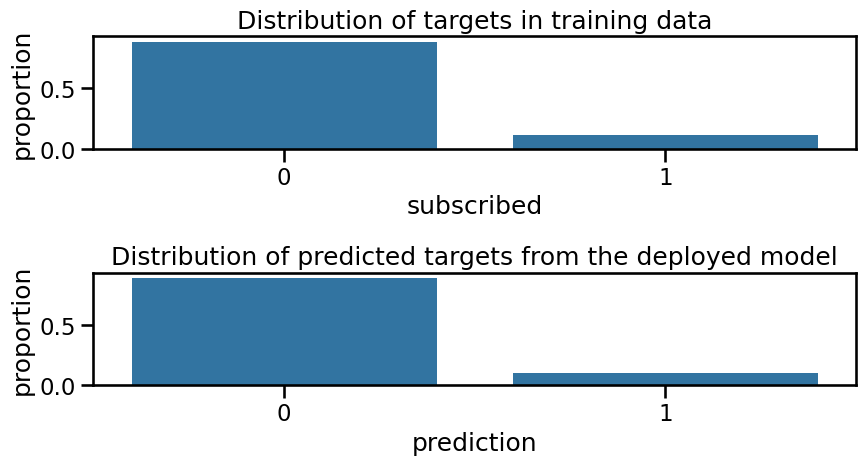

In [ ]:
# Create a figure with two subplots
plt.figure(figsize=(9, 5))

# Plot the distribution of targets in the training data
plt.subplot(211)
sns.countplot(x=ytrain, stat='proportion')
plt.title("Distribution of targets in training data")

# Plot the distribution of predicted targets from the deployed model
plt.subplot(212)
sns.countplot(x=prediction_logs_sample_df.prediction, stat='proportion')
plt.title("Distribution of predicted targets from the deployed model")

# Adjust layout to prevent overlap
plt.tight_layout()

The above plot indicates variation in the distributions between training targets and predicted targets. However, this variation is observed in a sample. How do we confirm that this is not an artifact of the sample? We answer this question by formalizing the thumb rule presented above as the following test: Let the proportion of the positive labels in training data (of size $n$) is $p$. Then the proportion of positive labels in the sample of prediction logs can be different from $p$ by at most $2\sqrt{p(1-p)/n}$ (i.e., the difference is no more than two standard deviations away). This logic is implemented in the code cells below:

In [ ]:
# Count the occurrences of each unique value in ytrain
ytrain.value_counts()

subscribed
0    29233
1     3713
Name: count, dtype: int64

In [ ]:
# Count the occurrences of each unique value in the 'prediction' column of prediction_logs_sample_df
prediction_logs_sample_df.prediction.value_counts()

prediction
0    68
1     8
Name: count, dtype: int64

In [ ]:
# Calculate the proportion of positive labels in the training data
p_pos_label_training_data = 3713 / (29233 + 3713)

# Calculate the proportion of positive labels in the sample logs
p_pos_label_sample_logs = 12 / 75

In [ ]:
# Display the calculated proportions
p_pos_label_training_data, p_pos_label_sample_logs

(0.11269956899168336, 0.16)

In [ ]:
# @title Target Check

p_pos_label_training_data = 0.1127 # @param
p_pos_label_sample_logs = 0.16 # @param
training_data_size = 41183 # @param

variance = (p_pos_label_training_data * (1-p_pos_label_training_data))/training_data_size
p_diff = abs(p_pos_label_training_data - p_pos_label_sample_logs)

if p_diff > 2 * math.sqrt(variance):
    print("Model Drift Detected!")
else:
    print("No Model Drift!")


Model Drift Detected!


## Test your understanding

1. What are typical factors that can lead to model drift in machine learning?

- Decrease in the number of features used in the model
- Introduction of a new data source that is consistent with the model’s training data
- Changes in the underlying data distribution over time
- Reduction in the computational resources allocated to the model

\
2. Imagine you are a data scientist working for a financial institution that specializes in personal loans. Over the past year, you’ve developed a machine learning model to predict the likelihood of loan default based on customer profiles and economic indicators. The model has been performing well, but with recent economic changes and shifts in customer behavior, you suspect that model drift might be occurring.

  Which of the following actions would be most effective in determining if model drift is affecting the accuracy of the credit risk model?

- Re-evaluate the model using the same historical data it was originally trained on
- Increase the frequency of model retraining without reviewing the new data
- Conduct a new feature importance analysis to identify any changes in feature relevance
- Wait for the annual financial report before making any assessments

# Data Drift Checks

## Live Features vs Training Features

Categorical data drift can be checked using the proportion test described in the previous section.

For numerical features, we use the following thumb rule: The mean of a numeric feature in production logs can be at most 2 standard deviations away from its mean in the training data. Note that here we are comparing a point estimate of production data accounting for expected variation in sampling.

Let us implement this thumb rule for one numeric feature: Age.

In [ ]:
# Calculate the mean and standard deviation of 'Age' in the training data
mean_age_training_data = Xtrain['Age'].mean()
std_age_training_data = Xtrain['Age'].std()

# Calculate the mean 'Age' from the sample logs
mean_age_sample_logs = prediction_logs_sample_df['Age'].mean()

In [ ]:
(mean_age_training_data, mean_age_sample_logs)

(40.02079980566605, 39.1578947368421)

In [ ]:
std_age_training_data

10.435801368579952

In [ ]:
# @title Feature Distribution Check

mean_feature_training_data = 40.020 # @param
mean_feature_sample_logs = 39.493 # @param
std_feature_training_data = 10.435 # @param

mean_diff = abs(mean_feature_training_data - mean_feature_sample_logs)

if mean_diff > 2 * std_feature_training_data:
    print("Data Drift Detected!")
else:
    print("No Data Drift!")


No Data Drift!


The current model stays in production unless we detect model drift or data drift.